In [1]:
import random
import numpy as np
import copy
import time
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
random.seed(1)
n=100 #number of objects
b=5 #number of bins
c=50

#Generate random locations
vj=random.choices(range(10, 100),k=n)
wj=random.choices(range(5, 20),k=n)

Solution Encoding

The solution is represented with an n by b matrix where n is the number of items and b is the
number of containers. Entry (i,j) represents whether item i is assigned to container j with binary
encoding.

The code below randomly generates a solution that might not be feasible. Each item has 1/3 chance to be put in the containers with equal probability.

In [3]:
#input: n-number of items; b-number of containers
#output: result-a table of arrangement that might not be feasible
def generate_solution(n,b):
    result=np.zeros((n,b))
    for i in range(n):
        #whether to put the item in a knapsack
        a=random.randint(0,2)
        if a==1:
            #decide to put in which knapsack
            j=random.randint(0,b-1)
            result[i,j]=1
    return result

The code below fixes an infeasible solution by randomly removing items from the overweighted bags.

In [4]:
#input: x-a table of arrangement that might not be feasible c-capacity
#output: x-a table of a feasible arrangement
def fix(x,c):
    #check whether the result is valid
    n,b=x.shape
    valid=True
    overweight={}
    for i in range(b):
        weight=0
        for j in range(n):
            weight+=wj[j]*x[j,i]
        if weight>c:
            valid=False
            overweight[i]=weight

    #randomly remove items until it meets the constraint
    if valid==False:
        for i,w in overweight.items():
            in_bag=[]
            for j in range(n):
                if x[j,i]==1:
                    in_bag.append(j)
            while w>c:
                a=random.randint(0,len(in_bag)-1)
                x[in_bag[a],i]=0
                w-=wj[in_bag[a]]
                in_bag.pop(a)
    return x

The code below is used to convert a numpy result table to a more readable one.

In [5]:
def final_table(x):
        container=list(range(1,b+1))
        container.append('Total')
        package=[]
        for i in range(b):
            package.append([])
            for j in range(n):
                if x[j,i]==1:
                    package[i].append(j+1)
        package.append('')
        
        profits=[]
        weights=[]
        for i in range(b):
            profit=0
            weight=0
            for j in package[i]:
                profit+=vj[j-1]
                weight+=wj[j-1]
            profits.append(profit)
            weights.append(weight)
        profits.append(sum(profits))
        weights.append('')
        data={'Container':container,'Packages':package,'Profit':profits,'Weight':weights}
        return pd.DataFrame(data)    

Mutation

For each item, it has a 1% chance of mutation. After the mutation, it will either be placed in another bag, or just removed from the bag.

In [6]:
def mutation(x):
    n,b=x.shape
    for i in range(n):
        #randomly choose a number among 1 to 1000, the number has 0.1% chance to be 100
        m=random.randint(1,100)
        if m==10:
            for j in range(b):
                if x[i,j]==1:
                    x[i,j]=0
            #randomly choose a container to put the item in, if k=b, then just remove the item from the containers
            k=random.randint(0,b)
            if k!=b:
                x[i,k]=1
    return x
    

Crossover

The crossover here is uniform crossover with p=0.5, which is randomly select the arrangement of each item from both parent.

In [7]:
#input: x,y-two feasible arrangements act as parents
#output: result-the offspring
def crossover(x,y):
    n,b=x.shape
    result=np.zeros((n,b))
    for i in range(n):
        a=random.randint(0,1)
        if a==0:
            for j in range(b):
                result[i,j]=x[i,j]
        else:
            for j in range(b):
                result[i,j]=y[i,j]
    return result

Fitness

Fitness in this case is just the total amount of profit.

In [8]:
#input: x-a table of a feasible arrangement
#output: profit-the fitness/total profit of this arrangement
def fitness(x):
    n,b=x.shape
    profit=0
    for i in range(n):
        for j in range(b):
            profit+=vj[i]*x[i,j]
    return profit

The initial population are uniformly randomly generated. 
The population size is 10. 
Mutation with probability of 1% is used as inertial operator.
Uniform crossover with personal best and global best are used as cognitive operator and social operator.

  Container                      Packages  Profit Weight
0         1              [13, 19, 47, 83]     350     50
1         2           [8, 18, 26, 75, 91]     416     50
2         3      [23, 51, 59, 69, 95, 97]     439     50
3         4       [7, 41, 42, 52, 54, 80]     500     50
4         5  [45, 53, 63, 82, 86, 93, 96]     545     48
5     Total                                  2250       


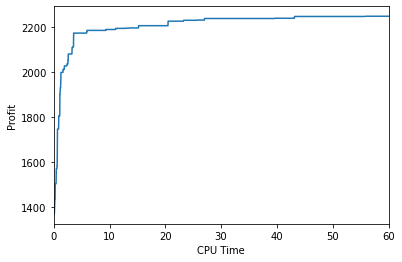

In [12]:
start=time.time()
#generate 10 initial solutions
population=[]
pbest_list=[]
pbest_fitness=[]
for i in range(10):
    a=generate_solution(n,b)
    d=fix(a,c)
    population.append(d)
    pbest_list.append(d)
    pbest_fitness.append(fitness(d))

gbest=population[0]
gbest_fitness=fitness(population[0])
for i in population:
    if fitness(i)>gbest_fitness:
        gbest=copy.deepcopy(i)
        gbest_fitness=fitness(i)

end=time.time()
time_list=[0]
value_list=[gbest_fitness]
while end-start<60:
    #Calculate the new state for each solution and update pbest
    for i in range(len(population)):
        j=mutation(population[i]) #inertia
        k=crossover(j,pbest_list[i]) #cognitive
        l=crossover(k,gbest) #social
        m=fix(l,c)
        population[i]=copy.deepcopy(m)
        if fitness(m)>pbest_fitness[i]:
            pbest_list[i]=copy.deepcopy(m)
            pbest_fitness[i]=fitness(m)
    #Update gbest
    for i in range(len(population)):
        if pbest_fitness[i]>gbest_fitness:
            gbest=copy.deepcopy(pbest_list[i])
            gbest_fitness=pbest_fitness[i]
        
    end=time.time()
    time_list.append(end-start)
    value_list.append(gbest_fitness)

print(final_table(gbest))
plt.xlabel('CPU Time')
plt.ylabel('Profit')
plt.xlim((0,60))
plt.plot(time_list,value_list)